<a href="https://colab.research.google.com/github/rambod-rahmani/arch-linux-install/blob/master/package-damage-detection/exp10-yolov11s-batch32-cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [ ]:
%pip install ultralytics wandb weave matplotlib pyyaml albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.0/585.0 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 42.2/235.7 GB disk)


In [ ]:
import wandb
wandb.login()

# Start W&B manually before model.train()
wandb.init(project="Package Damage", name="yolov11s-batch32-consine")

# Log custom config values
wandb.config.update({
    "model": "yolo11s.pt",
    "epochs": 300,
    "patience": 20,
    "lr0": 0.002,
    "imgsz": 640,
    "batch": 32,
    "dataset": "augmented-v1",
    "scheduler": "cosine",
    "lrf": 0.01,
    "description": "Train with Batch size 32, early stopping, reduced LR and consine learning rate scheduler"
})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rambodrahmani (wau-unipi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/WAU/damage-dataset'

data.yaml	    README.roboflow.txt  train	yolov11.zip
README.dataset.txt  test		 valid


# **Dataset**

In [ ]:
import os
import zipfile
import urllib.request

drive_dataset_dir = "/content/drive/MyDrive/Colab Notebooks/WAU/damage-dataset"

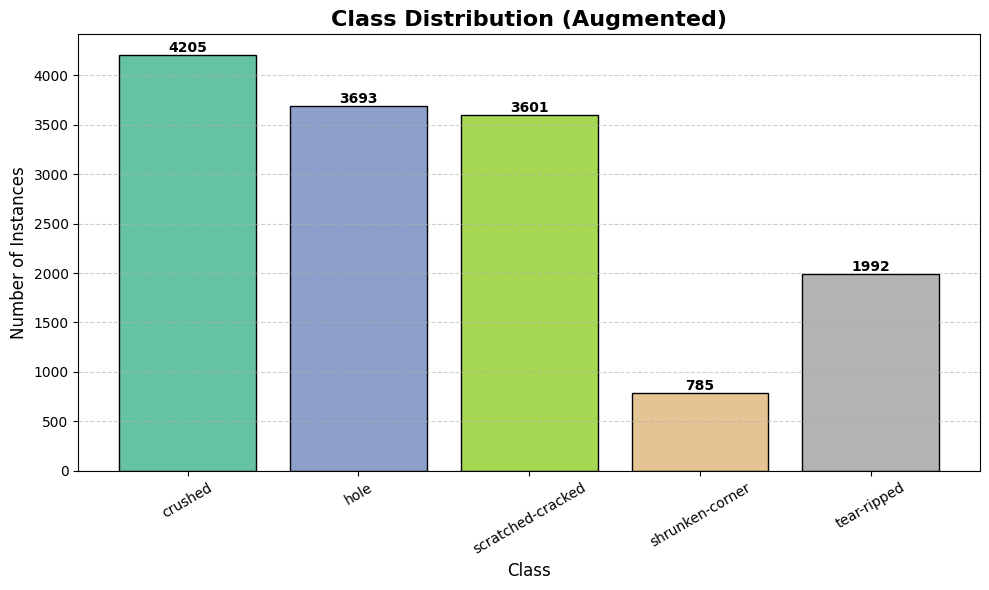

,Class,Count
0,crushed,4205
1,hole,3693
2,scratched-cracked,3601
3,shrunken-corner,785
4,tear-ripped,1992


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import yaml
import pandas as pd
from collections import Counter

# Use the augmented dataset path relative to drive_dataset_dir
augmented_dataset_path = Path(drive_dataset_dir).parent / "damage-dataset-augmented"

# Load class names from data.yaml
with open(augmented_dataset_path / "data.yaml", "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"]
label_dirs = [
    augmented_dataset_path / "train/labels",
    augmented_dataset_path / "valid/labels",
    augmented_dataset_path / "test/labels"
]

# Count class IDs
class_counts = Counter()
for label_dir in label_dirs:
    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

# Prepare labels and counts
labels = [class_names[i] for i in range(len(class_names))]
counts = [class_counts[i] for i in range(len(class_names))]

# Choose color palette
cmap = matplotlib.colormaps.get_cmap('Set2')
colors = cmap(np.linspace(0, 1, len(labels)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, counts, color=colors, edgecolor='black')

# Add value annotations
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Style the plot
ax.set_title("Class Distribution (Augmented)", fontsize=16, fontweight='bold')
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Number of Instances", fontsize=12)
ax.tick_params(axis='x', labelrotation=30)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 📋 Print class distribution table below the plot
df = pd.DataFrame({"Class": labels, "Count": counts})
display(df)

# **Train**

This experiment trains the YOLOv11n model on the augmented package damage dataset with two key improvements:

* **Early Stopping (`patience=20`)**: Automatically halts training if validation metrics do not improve for 20 consecutive epochs, helping prevent overfitting beyond the optimal point (previously observed around epoch 67).
* **Reduced Learning Rate (`lr0=0.005`)**: Lowers the initial learning rate from the default 0.01 to 0.005 to promote more stable convergence, especially important when training on a visually subtle and class-imbalanced defect detection task.
* **Try a different model scale**: Larger models might better tolerate distorted features, and smaller ones might overfit stretched shapes.
* **Batch Size**: increased to `32`.

In [ ]:
from ultralytics import settings, YOLO

settings.update(wandb=True)

augmented_dataset_path = Path(drive_dataset_dir).parent / "damage-dataset-augmented"

model = YOLO("yolo11s.pt")

# Train on the augmented dataset
model.train(
    data=str(augmented_dataset_path / "data.yaml"),
    epochs=300,
    patience=20,
    imgsz=640,
    project="Package Damage",
    name="yolov11s-batch32-consine",
    exist_ok=True,
    val=True,
    lr0=0.002,
    optimizer="SGD",
    batch=32,
    lrf=0.01,
    cos_lr=True,

    # General-purpose augmentations
    hsv_h=0.015,        # Hue variation
    hsv_s=0.7,          # Saturation variation
    hsv_v=0.4,          # Brightness variation
    degrees=10.0,       # Random rotation
    translate=0.1,      # Random shift
    scale=0.5,          # Random scale
    shear=2.0,          # Random shear
    perspective=0.001,  # Slight perspective warping
    fliplr=0.5,         # Horizontal flip
    mosaic=1.0,         # Mosaic augmentation (very effective)
    mixup=0.2,          # Mix images and labels
    cutmix=0.2,         # Cut and paste
)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.2, data=/content/drive/MyDrive/Colab Notebooks/WAU/damage-dataset-augmented/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s-batch32-consine, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, ov

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    821343  ultralytics.nn.modules.head.Detect           [5, [128, 256, 512]]          
YOLO11s summary: 181 layers, 9,429,727 parameters, 9,429,711 gradients, 21.6 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 64.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.2±0.1 MB/s, size: 44.0 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/WAU/damage-dataset-augmented/train/labels.cache... 15063 images, 5347 backgrounds, 0 corrupt: 100%|██████████| 15063/15063 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8111, len(boxes) = 12301. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.2±0.1 MB/s, size: 36.5 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/WAU/damage-dataset-augmented/valid/labels.cache... 1287 images, 389 backgrounds, 0 corrupt: 100%|██████████| 1287/1287 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1118, len(boxes) = 1274. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to Package Damage/yolov11s-batch32-consine/labels.jpg... 
optimizer: SGD(lr=0.002, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to Package Damage/yolov11s-batch32-consine
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      7.58G      2.175      4.425      2.277         41        640: 100%|██████████| 471/471 [28:18<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


                   all       1287       1274      0.174     0.0615     0.0426     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      9.14G      1.909      3.309      2.054         42        640: 100%|██████████| 471/471 [01:28<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]

                   all       1287       1274      0.201      0.175      0.122     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      9.14G      1.878      3.074      2.028         29        640: 100%|██████████| 471/471 [01:25<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


                   all       1287       1274      0.207      0.159     0.0982     0.0338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      9.14G      1.908      3.089      2.059         32        640: 100%|██████████| 471/471 [01:25<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]

                   all       1287       1274      0.456      0.184      0.152     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      9.14G       1.87      2.975      2.028         37        640: 100%|██████████| 471/471 [01:25<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]

                   all       1287       1274      0.295      0.214      0.193     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      9.14G      1.835      2.907      2.008         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]


                   all       1287       1274        0.3      0.233      0.209     0.0708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      9.14G      1.823      2.857      1.991         48        640: 100%|██████████| 471/471 [01:25<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]

                   all       1287       1274      0.284      0.207      0.161     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      9.15G      1.813      2.836      1.997         52        640: 100%|██████████| 471/471 [01:25<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


                   all       1287       1274      0.378      0.279      0.249     0.0873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      9.15G      1.791      2.792      1.978         45        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


                   all       1287       1274      0.408      0.269      0.256     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      9.15G      1.789      2.727      1.952         33        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


                   all       1287       1274      0.584      0.248      0.255     0.0922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      9.15G       1.76      2.699      1.947         36        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


                   all       1287       1274      0.367      0.285      0.253     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      9.15G      1.758      2.673      1.939         52        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]


                   all       1287       1274      0.361      0.263      0.249     0.0894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      9.15G      1.762       2.66      1.947         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]

                   all       1287       1274      0.406       0.29       0.28      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      9.15G      1.732      2.611      1.916         53        640: 100%|██████████| 471/471 [01:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.20it/s]

                   all       1287       1274      0.407      0.289      0.268        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      9.15G      1.736      2.578      1.913         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]

                   all       1287       1274      0.474      0.303      0.285      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      9.15G      1.723      2.545      1.905         37        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]

                   all       1287       1274      0.434      0.321      0.302      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      9.15G      1.718      2.549      1.894         57        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]

                   all       1287       1274      0.388      0.298      0.287      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      9.15G       1.71      2.507       1.89         47        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.20it/s]

                   all       1287       1274      0.466      0.327      0.308      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      9.15G      1.698      2.477       1.88         38        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]

                   all       1287       1274      0.402       0.29      0.293      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      9.15G      1.696      2.482      1.872         54        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]

                   all       1287       1274      0.515      0.323      0.323      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      9.15G      1.692      2.432      1.865         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]

                   all       1287       1274      0.536      0.299      0.323      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      9.15G       1.69      2.442      1.858         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]

                   all       1287       1274      0.533      0.339      0.332      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      9.15G      1.678      2.416       1.85         46        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]

                   all       1287       1274      0.669      0.309      0.331      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      9.15G      1.678      2.399      1.856         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]

                   all       1287       1274      0.636      0.311      0.331      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      9.15G      1.674       2.37       1.85         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]

                   all       1287       1274      0.482      0.341      0.342       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      9.15G       1.66      2.371      1.839         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]

                   all       1287       1274      0.566      0.335      0.335      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      9.15G      1.661      2.342      1.844         44        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]

                   all       1287       1274      0.577      0.347      0.339       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      9.15G      1.657      2.336      1.831         44        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]

                   all       1287       1274       0.56      0.322      0.324      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      9.15G      1.644       2.32      1.827         52        640: 100%|██████████| 471/471 [01:24<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]

                   all       1287       1274      0.462      0.331      0.334      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      9.15G      1.641      2.299      1.816         44        640: 100%|██████████| 471/471 [01:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]

                   all       1287       1274      0.489      0.347      0.346      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      9.15G      1.635      2.272      1.813         31        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]

                   all       1287       1274      0.648      0.345      0.345      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      9.15G      1.635      2.269       1.81         54        640: 100%|██████████| 471/471 [01:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.25it/s]

                   all       1287       1274      0.467      0.341      0.332      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      9.15G      1.638      2.255      1.808         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]

                   all       1287       1274      0.543      0.342      0.333      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      9.15G      1.631      2.239      1.803         44        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]

                   all       1287       1274      0.551      0.346      0.343      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      9.15G      1.628      2.238      1.792         31        640: 100%|██████████| 471/471 [01:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]

                   all       1287       1274      0.557      0.343      0.351      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      9.15G      1.628      2.222      1.794         38        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]

                   all       1287       1274      0.573      0.325      0.344      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      9.15G      1.626      2.204      1.784         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]

                   all       1287       1274      0.582      0.345      0.355      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      9.15G      1.625      2.192      1.781         34        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.569      0.353      0.354      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      9.15G      1.617      2.185      1.776         46        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]

                   all       1287       1274      0.502      0.372      0.355      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      9.15G      1.607      2.165      1.781         37        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.574      0.378      0.357      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      9.15G       1.61      2.185      1.772         49        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]

                   all       1287       1274      0.525      0.382      0.354      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      9.15G      1.602      2.126      1.758         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]

                   all       1287       1274      0.559      0.357      0.347      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      9.15G      1.591       2.12      1.758         54        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]

                   all       1287       1274        0.5      0.375      0.353      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      9.15G       1.59      2.109      1.751         31        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]

                   all       1287       1274      0.556      0.363      0.355      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      9.15G      1.576      2.096      1.741         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.586      0.355      0.354      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      9.15G      1.589      2.087      1.748         65        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.28it/s]

                   all       1287       1274      0.486       0.35      0.352      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      9.15G      1.569      2.056      1.738         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]

                   all       1287       1274      0.508      0.336      0.355      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      9.15G      1.579      2.058      1.742         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.20it/s]

                   all       1287       1274      0.481      0.341      0.349       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      9.15G      1.569      2.068      1.727         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]

                   all       1287       1274      0.689      0.345       0.35      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      9.15G      1.585      2.067      1.736         41        640: 100%|██████████| 471/471 [01:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.22it/s]

                   all       1287       1274      0.674       0.36      0.358      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      9.15G       1.57      2.028      1.725         36        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]

                   all       1287       1274      0.581      0.357      0.365      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      9.15G      1.566      2.012      1.728         36        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]

                   all       1287       1274       0.55      0.356      0.361       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      9.15G      1.574      2.022      1.729         46        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]

                   all       1287       1274      0.511      0.371      0.362      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      9.15G      1.566      2.015       1.72         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]

                   all       1287       1274      0.526      0.376      0.362      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      9.15G      1.544       1.99      1.703         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]

                   all       1287       1274      0.527      0.381      0.362      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      9.15G      1.552      2.008      1.711         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]

                   all       1287       1274      0.516      0.379      0.371      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      9.15G      1.544      1.963      1.696         56        640: 100%|██████████| 471/471 [01:23<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]

                   all       1287       1274      0.511       0.38      0.368      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      9.15G      1.548      1.974      1.699         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.20it/s]

                   all       1287       1274      0.518      0.375      0.361       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      9.15G      1.547      1.971      1.707         60        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]

                   all       1287       1274       0.56      0.371      0.363       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      9.15G      1.551      1.966      1.708         38        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]

                   all       1287       1274      0.559      0.373      0.361       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      9.15G      1.544      1.939      1.697         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.476      0.374      0.365       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      9.15G       1.54      1.943      1.693         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]

                   all       1287       1274      0.477      0.373      0.367      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      9.15G      1.535      1.933      1.686         43        640: 100%|██████████| 471/471 [01:24<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.20it/s]

                   all       1287       1274      0.475      0.376      0.368      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      9.15G      1.535      1.914      1.683         27        640: 100%|██████████| 471/471 [01:24<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]

                   all       1287       1274      0.559      0.374      0.372      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      9.15G      1.533       1.93      1.686         42        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.22it/s]

                   all       1287       1274      0.543      0.373      0.368      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      9.15G      1.532      1.919      1.684         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]

                   all       1287       1274      0.519      0.377      0.369      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      9.15G      1.525      1.903      1.677         51        640: 100%|██████████| 471/471 [01:24<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]

                   all       1287       1274      0.522      0.376      0.369      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      9.15G       1.52       1.88      1.676         35        640: 100%|██████████| 471/471 [01:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]

                   all       1287       1274      0.505       0.38      0.368      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      9.15G      1.514      1.874      1.669         33        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]

                   all       1287       1274      0.499      0.386      0.371      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      9.15G       1.52      1.897       1.68         52        640: 100%|██████████| 471/471 [01:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]

                   all       1287       1274      0.496      0.385      0.369      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      9.15G      1.503      1.853      1.655         56        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]

                   all       1287       1274      0.525      0.364      0.371      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      9.15G      1.506      1.825      1.651         48        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]

                   all       1287       1274      0.486      0.387      0.369      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      9.15G      1.512      1.863      1.652         35        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.485      0.392      0.371      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      9.15G      1.513      1.844      1.662         65        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]

                   all       1287       1274      0.492      0.388      0.371      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      9.15G      1.493       1.82      1.643         38        640: 100%|██████████| 471/471 [01:23<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]

                   all       1287       1274      0.487      0.388      0.369      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      9.15G      1.496      1.823      1.651         35        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.22it/s]

                   all       1287       1274      0.506      0.375       0.37      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      9.15G      1.491      1.822       1.64         40        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]

                   all       1287       1274       0.51      0.371       0.37      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      9.15G      1.492      1.805      1.642         37        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]

                   all       1287       1274      0.537      0.368      0.374      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      9.15G       1.49        1.8      1.638         35        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.536      0.369      0.373      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      9.15G      1.493      1.798       1.64         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]

                   all       1287       1274      0.534      0.369      0.373      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      9.15G      1.491       1.81      1.643         39        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]

                   all       1287       1274      0.531      0.368      0.373      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      9.15G      1.476      1.765      1.623         44        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.38it/s]

                   all       1287       1274      0.528       0.37      0.373      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      9.15G      1.469      1.757       1.62         42        640: 100%|██████████| 471/471 [01:24<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]

                   all       1287       1274      0.528       0.37      0.374      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      9.15G      1.476      1.756      1.624         42        640: 100%|██████████| 471/471 [01:24<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.33it/s]

                   all       1287       1274      0.522      0.372      0.373      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      9.15G      1.476      1.764      1.626         41        640: 100%|██████████| 471/471 [01:24<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.25it/s]

                   all       1287       1274      0.524      0.369      0.371      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      9.15G      1.466      1.754      1.616         42        640: 100%|██████████| 471/471 [01:24<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.37it/s]

                   all       1287       1274      0.525      0.371      0.371      0.145
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 66, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



86 epochs completed in 2.599 hours.
Optimizer stripped from Package Damage/yolov11s-batch32-consine/weights/last.pt, 19.2MB
Optimizer stripped from Package Damage/yolov11s-batch32-consine/weights/best.pt, 19.2MB

Validating Package Damage/yolov11s-batch32-consine/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]


                   all       1287       1274      0.516      0.375      0.366      0.146
               crushed        368        408      0.631      0.539      0.548      0.221
                  hole        320        418      0.644      0.512      0.515      0.189
     scratched-cracked        118        143      0.505      0.371      0.334      0.141
       shrunken-corner         46         47       0.27     0.0213     0.0404     0.0208
           tear-ripped        226        258      0.528      0.434      0.393      0.156
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to Package Damage/yolov11s-batch32-consine


lr/pg0,█▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
lr/pg1,████████████▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁
lr/pg2,▁▄███████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆
metrics/mAP50(B),▂▁▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇██████████████
metrics/mAP50-95(B),▁▂▄▄▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████████████████████
metrics/precision(B),▁▁▂▄▃▄▄▅▄▅▇▆▆▅▆▆▆▆▅▇▅▅██▆▆▆▆▅▆▅▆▅▅▅▆▆▆▆▆
metrics/recall(B),▁▂▄▅▆▆▆▅▆▅▆▆▇▆▇▇██▇█▇▇▇▇▇█▇▇█▇███▇█▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▅▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7924ba1f3610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## 📊 Updated Performance Comparison Table

| Model        | Params (M) | GFLOPs | Batch | Optimizer | Scheduler | mAP50     | mAP50-95  | Precision | Recall    | Inference (ms) | Training Time |
| ------------ | ---------- | ------ | ----- | --------- | --------- | --------- | --------- | --------- | --------- | -------------- | ------------- |
| **YOLOv11n** | 2.6        | 6.4    | 16    | SGD       | default   | 0.361     | 0.143     | 0.611     | 0.340     | 0.6            | 3.2h (97 ep)  |
| **YOLOv11s** | 9.4        | 21.3   | 16    | SGD       | default   | **0.377** | **0.152** | 0.585     | **0.372** | 1.0            | 5.6h (147 ep) |
| **YOLOv11s** | 9.4        | 21.3   | 32    | SGD       | default   | 0.375     | 0.149     | **0.661** | 0.369     | **0.8**        | 2.5h (68 ep)  |
| **YOLOv11m** | 20.0       | 67.7   | 16    | SGD       | default   | 0.369     | 0.146     | 0.512     | 0.360     | 1.8            | 3.0h (71 ep)  |
| **YOLOv11s** | 9.4        | 21.3   | 32    | AdamW     | none      | 0.304     | 0.122     | 0.588     | 0.293     | 0.8            | 2.9h (103 ep) |
| **YOLOv11s** | 9.4        | 21.3   | 32    | SGD       | cosine    | 0.366     | 0.146     | 0.516     | 0.375     | 0.8            | 2.6h (86 ep)  |

🔍 Key Conclusions from Experimental Results

**1. Best Overall Performance**
- YOLOv11s with Batch 16 + SGD (default scheduler) achieved the highest mAP50 (0.377) and mAP50-95 (0.152), along with strong recall (0.372).
- This suggests that default SGD with moderate batch size (16) is still the most balanced setting for detection accuracy.

<br>

**2. Batch Size Impact**
- Increasing batch size from 16 → 32 in YOLOv11s maintained similar mAP50 (0.375) and slightly reduced mAP50-95 (0.149), but drastically increased precision to 0.661.
- However, recall slightly decreased, suggesting the model became more conservative (fewer false positives, more false negatives).
- ✅ Conclusion: Batch size 32 helps with confidence (precision), but might slightly reduce coverage (recall).

<br>

**3. Model Size Comparison**
- YOLOv11n (smallest model) performed surprisingly well with mAP50 = 0.361 using just 2.6M parameters.
- YOLOv11m (larger model) had only a marginal mAP50 gain (0.369) at the cost of much higher compute (67.7 GFLOPs).
- ✅ Conclusion: Scaling up to m does not provide meaningful accuracy gains; s hits the best tradeoff.

<br>

**4. Optimizer Effects**
- AdamW significantly underperformed (mAP50 = 0.304, mAP50-95 = 0.122) despite a longer training (103 epochs).
- It had the lowest recall (0.293) and relatively low precision.
- ❌ Conclusion: AdamW was detrimental here, possibly due to improper LR scheduling or poor fit for this detection task.

<br>

**5. Learning Rate Scheduler**
- Using a cosine scheduler gave results similar to default SGD:
 - mAP50 = 0.366, mAP50-95 = 0.146, precision and recall very comparable.
 - Slightly better tear-ripped and hole detection, based on breakdown.
- ✅ Conclusion: Cosine works as well as default, with more stable learning rate decay, and can be safely used.